In [3]:
import pandas as pd
import numpy as np
import os

# Paths
PROCESSED_PATH = "../data/processed/tabular/"
OUTPUT_FILE = os.path.join(PROCESSED_PATH, "cargo2000_features.csv")

# Load cleaned C2K dataset
df_c2k = pd.read_csv(os.path.join(PROCESSED_PATH, "cargo2000_clean.csv"))
print("✅ Loaded Cargo2000:", df_c2k.shape)

# Ensure '?' is handled
df_c2k.replace("?", np.nan, inplace=True)

# Identify planned vs effective columns
planned_cols = [c for c in df_c2k.columns if c.endswith("_p")]
effective_cols = [c for c in df_c2k.columns if c.endswith("_e")]

print("Planned cols:", planned_cols[:5])
print("Effective cols:", effective_cols[:5])


✅ Loaded Cargo2000: (3943, 130)
Planned cols: ['i1_rcs_p', 'i1_dep_1_p', 'i1_rcf_1_p', 'i1_dep_2_p', 'i1_rcf_2_p']
Effective cols: ['i1_rcs_e', 'i1_dep_1_e', 'i1_rcf_1_e', 'i1_dep_2_e', 'i1_rcf_2_e']


Compute Delays

In [4]:
# Compute delay for each leg (effective - planned)
for p in planned_cols:
    e = p.replace("_p", "_e")
    if e in df_c2k.columns:
        delay_col = p.replace("_p", "_delay")
        df_c2k[delay_col] = pd.to_numeric(df_c2k[e], errors="coerce") - pd.to_numeric(df_c2k[p], errors="coerce")


In [5]:
id_col = "shipment_id" if "shipment_id" in df_c2k.columns else df_c2k.index

delay_cols = [c for c in df_c2k.columns if c.endswith("_delay")]

#Aggregate
df_features = pd.DataFrame({
    "shipment_id": id_col,
    "num_legs": df_c2k[delay_cols].notna().sum(axis=1),
    "total_delay": df_c2k[delay_cols].sum(axis=1, skipna=True),
    "max_delay": df_c2k[delay_cols].max(axis=1, skipna=True),
    "avg_delay": df_c2k[delay_cols].mean(axis=1, skipna=True)
})

print("✅ Feature dataset shape:", df_features.shape)
df_features.head()

✅ Feature dataset shape: (3943, 5)


,shipment_id,num_legs,total_delay,max_delay,avg_delay
0,0,32,-6615.0,2625.0,-206.71875
1,1,32,-6726.0,2010.0,-210.18750
2,2,32,-10390.0,970.0,-324.68750
3,3,32,-11245.0,793.0,-351.40625
4,4,32,-10205.0,657.0,-318.90625


In [6]:
df_features.to_csv(OUTPUT_FILE, index=False)
print(f"💾 Saved cargo2000 features → {OUTPUT_FILE}")

💾 Saved cargo2000 features → ../data/processed/tabular/cargo2000_features.csv


Visualizations

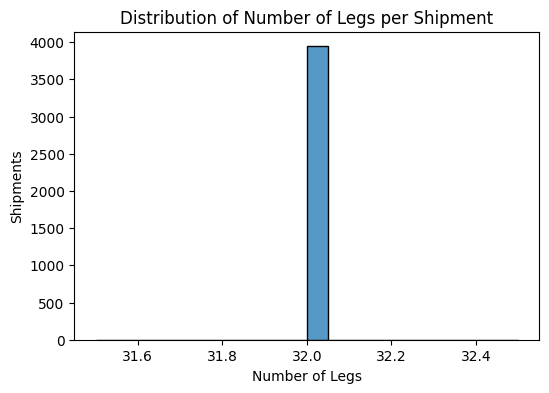

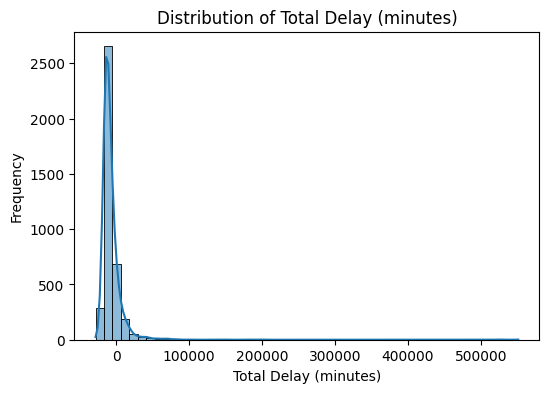

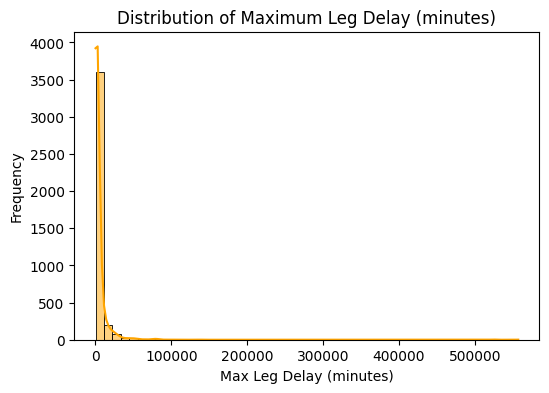

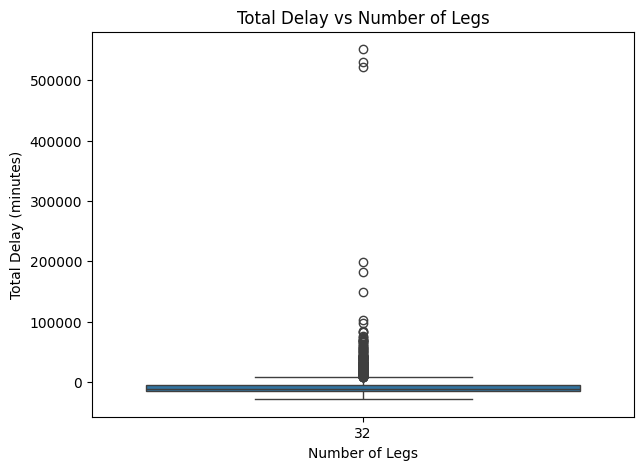

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram: number of legs per shipment
plt.figure(figsize=(6,4))
sns.histplot(df_features["num_legs"], bins=20, kde=False)
plt.title("Distribution of Number of Legs per Shipment")
plt.xlabel("Number of Legs")
plt.ylabel("Shipments")
plt.show()

# Histogram: total delay
plt.figure(figsize=(6,4))
sns.histplot(df_features["total_delay"].dropna(), bins=50, kde=True)
plt.title("Distribution of Total Delay (minutes)")
plt.xlabel("Total Delay (minutes)")
plt.ylabel("Frequency")
plt.show()

# Histogram: max delay
plt.figure(figsize=(6,4))
sns.histplot(df_features["max_delay"].dropna(), bins=50, kde=True, color="orange")
plt.title("Distribution of Maximum Leg Delay (minutes)")
plt.xlabel("Max Leg Delay (minutes)")
plt.ylabel("Frequency")
plt.show()

# Boxplot: total delay by number of legs
plt.figure(figsize=(7,5))
sns.boxplot(x="num_legs", y="total_delay", data=df_features)
plt.title("Total Delay vs Number of Legs")
plt.xlabel("Number of Legs")
plt.ylabel("Total Delay (minutes)")
plt.show()
